<a href="https://colab.research.google.com/github/Shruti192/Code_Summarizer/blob/main/Code_summarizer_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Implementing a sequence to sequence translation architecture to generate summary strings from code snippets.**


In [ ]:
############################# Data Cleaning and Pre-Processing #########################################
import re
import pandas as pd
import numpy as np

############  Function to remove non-alphabetic characters (Data Cleaning)
def clean_text(column):
    for row in column:
        row = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1',  str(row))).split()
        row = ' '.join(row)
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()
        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",.\}`$\{;@?~*!+=_\//1234567890]", " ", str(row)).lower()
        row = re.sub(r"\\b(\\w+)(?:\\W+\\1\\b)+", "", str(row)).lower()
        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()
        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()
        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()
        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass
        row = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1',  str(row))).split()
        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()
        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()
        yield row
  

df_code = pd.read_csv('/content/drive/MyDrive/NLP/python_Sample_dataset.csv')
df_code_p = df_code[["code","docstring"]]

processed_code= clean_text(df_code_p['code'])
processed_summary = clean_text(df_code_p['docstring'])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Time to clean up everything: 0.14 mins


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


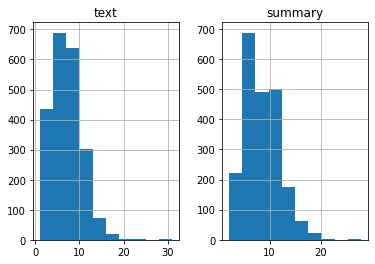

In [ ]:
###############  Data Pre-Processing
import spacy
from time import time

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 
t = time()
# Process text as batches and yield Doc objects in order
code = [str(doc) for doc in nlp.pipe(processed_code, batch_size=50)]
summary = [ str(doc)  for doc in nlp.pipe(processed_summary, batch_size=50)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))
df_code_p['code'] = code
df_code_p['docstring'] = summary


####### Analyzing distribution of code length and summary length
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in df_code_p['code']:
    text_count.append(len(sent.split()))

for sent in df_code_p['docstring']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 
graph_df['text'] = text_count
graph_df['summary'] = summary_count
graph_df.hist(bins = 10)
plt.show()

max_code_len = 40
max_summary_len = 40


In [ ]:
######    Select the Summaries and Text which fall below max length 
import numpy as np

cleaned_code = np.array(df_code_p['code'])
cleaned_summary= np.array(df_code_p['docstring'])
short_text = []
short_summary = []
for i in range(len(cleaned_code)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_code[i].split()) <= max_code_len:
        short_text.append(cleaned_code[i])
        short_summary.append(cleaned_summary[i])
        
post_code = pd.DataFrame({'code': short_text,'summary': short_summary})
# print(post_code.head(100))
print(len(post_code))
post_code['summary'] = post_code['summary'].apply(lambda x: 'sostok ' + x         + ' eostok')
# print(post_code.head(2))




from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    np.array(post_code["code"]), 
    np.array(post_code["summary"]),
    test_size=0.15,
    random_state=0,
    shuffle=True,
)
print(x_train.shape, x_test.shape)

2163
(1838,) (325,)


In [ ]:
print(len(x_train))

1838


In [ ]:
################  tokenization and creation of x vocabolary 
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import numpy as np
import gensim
from gensim.utils import tokenize
from gensim.models import Word2Vec, FastText
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ############### Preparing x_vocab or code_vocab
# x_tokenizer = Tokenizer() 
# x_tokenizer.fit_on_texts(list(x_train))
# threshold = 1
# cnt_infrequent = 0
# total_cnt = 0
# for key, value in x_tokenizer.word_counts.items():
#     total_cnt = total_cnt + 1
#     if value < threshold:
#         cnt_infrequent = cnt_infrequent + 1 
# print("% of not frequent words in vocabulary: ", (cnt_infrequent / total_cnt) * 100)

# # Prepare a tokenizer, again -- by not considering the rare words
# x_tokenizer = Tokenizer(num_words = total_cnt - cnt_infrequent) 
# x_tokenizer.fit_on_texts(list(x_train))
# print(x_tokenizer)

# list(tokenize(text))
x_tokenized_train=[]
print(x_train.shape, x_test.shape)
for row in x_train:
  row_ = list(tokenize(row))
  x_tokenized_train.append(row_)
print(len(x_tokenized_train))
# train model
x_model = gensim.models.Word2Vec(x_tokenized_train, min_count = 1, size = 64, window = 5, sg = 1)
# summarize the loaded model

x_vocab = list(x_model.wv.vocab)
print(x_vocab)
# X_train = x_model_train[x_model_train.wv.vocab]
# X_train = x_model_train.wv[x_tokenized]
X_train = []
for tokenized_sentence in x_tokenized_train:
  temp_list = []
  print(tokenized_sentence)
  for word in tokenized_sentence:
    word_vector = x_model.wv[word]
    temp_list.append(word_vector)
  temp_list = np.array(temp_list)
  padded = np.zeros((40, 64))
  padded[:temp_list.shape[0], :temp_list.shape[1]] = temp_list
  X_train.append(temp_list)
X_train = np.array(X_train)
print(X_train[0].shape)
print(X_train[1].shape)
print(X_train[10].shape)


# print(X_train)
x_tokenized_test=[]
for row in x_test:
  row_ = list(tokenize(row))
  x_tokenized_test.append(row_)
print(len(x_tokenized_test))

x_test_list = []
for i in range(len(x_tokenized_test)):
  x_preprocessed = ""
  for word in x_tokenized_test[i]:
    if word in x_vocab:
      # print(word)
      # print('1 : ',x_tokenized_test[i])
      # x_tokenized_test[i].remove(word)
      # print('2 : ',x_tokenized_test[i])
      x_preprocessed += (word + " ")
  x_test_list.append(x_preprocessed)

X_test = []
for tokenized_sentence in x_tokenized_test:
  temp_list = []
  for word in tokenized_sentence:
    word_vector = x_model.wv[word]
    temp_list.append(word_vector)
  temp_list = np.array(temp_list)
  padded = np.zeros((40, 64))
  padded[:temp_list.shape[0], :temp_list.shape[1]] = temp_list
  X_test.append(temp_list)
X_test = np.array(X_test)
print(X_test.shape)

# x_voc = x_tokenizer.num_words + 1
# print("Size of vocabulary in X = {}".format(x_voc))


(1838,) (325,)
1838
['df', 'fillna', 'method', 'ffill', 'inplace', 'true', 'value', 'for', 'pair', 'in', 'zip', 'a', 'b', 'p', 'wait', 'datetime', 'strptime', 'd', 'm', 'y', 'h', 'all', 'list', 'plot', 'x', 'col', 'name', 'style', 'o', 'str', 'wi', 'wordids', 'sum', 'success', 's', 'join', 'soup', 'find', 'text', 'plt', 'colorbar', 'im', 'ax', 'outfile', 'write', 'n', 'itemlist', 'multiply', 'c', 'axis', 'index', 'levels', 'from', 'subprocess', 'import', 'call', 'astr', 'sys', 'path', 'append', 'to', 'test', 'apple', 'decode', 'iso', 'encode', 'utf', 'isin', 'data', 'frame', 'count', 'groupby', 'city', 'size', 'reset', 'split', 'if', 'not', 'males', 'gender', 'male', 'year', 'i', 'range', 'new', 'copy', 'deepcopy', 'old', 'sorted', 'sort', 'key', 'itemgetter', 'dict', 'canvas', 'delete', 'time', 'strftime', 'open', 'very', 'important', 'txt', 'r', 'read', 'changed', 'int', 'f', 'isdigit', 'else', 'original', 'xc', 'xbc', 'raw', 'unicode', 'escape', 'dummy', 'agg', 'returns', 'np', 'mea

IndexError: ignored

In [ ]:
################  tokenization and creation of x vocabolary 
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import numpy as np
import gensim
from gensim.utils import tokenize
from gensim.models import Word2Vec, FastText
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ############### Preparing x_vocab or code_vocab
# x_tokenizer = Tokenizer() 
# x_tokenizer.fit_on_texts(list(x_train))
# threshold = 1
# cnt_infrequent = 0
# total_cnt = 0
# for key, value in x_tokenizer.word_counts.items():
#     total_cnt = total_cnt + 1
#     if value < threshold:
#         cnt_infrequent = cnt_infrequent + 1 
# print("% of not frequent words in vocabulary: ", (cnt_infrequent / total_cnt) * 100)

# # Prepare a tokenizer, again -- by not considering the rare words
# x_tokenizer = Tokenizer(num_words = total_cnt - cnt_infrequent) 
# x_tokenizer.fit_on_texts(list(x_train))
# print(x_tokenizer)

# list(tokenize(text))
y_tokenized_train=[]
for row in y_train:
  row_ = list(tokenize(row))
  y_tokenized_train.append(row_)

# train model
y_model = gensim.models.Word2Vec(y_tokenized_train, min_count = 1, size = 64, window = 5, sg = 1)
# summarize the loaded model

y_vocab = list(y_model.wv.vocab)
# X_train = x_model_train[x_model_train.wv.vocab]
# X_train = x_model_train.wv[x_tokenized]
Y_train = []
for tokenized_sentence in y_tokenized_train:
  temp_list = []
  for word in tokenized_sentence:
    word_vector = y_model.wv[word]
    temp_list.append(word_vector)
  temp_list = np.array(temp_list)
  Y_train.append(temp_list)
Y_train = np.array(Y_train)
print(Y_train.shape)

# print(X_train)
y_tokenized_test=[]
for row in y_test:
  row_ = list(tokenize(row))
  y_tokenized_test.append(row_)

y_test_list = []
for i in range(len(y_tokenized_test)):
  y_preprocessed = ""
  for word in y_tokenized_test[i]:
    if word in y_vocab:
      # print(word)
      # print('1 : ',x_tokenized_test[i])
      # x_tokenized_test[i].remove(word)
      # print('2 : ',x_tokenized_test[i])
      y_preprocessed += (word + " ")
  y_test_list.append(y_preprocessed)

y_tokenized_test=[]
for row in y_test_list:
  row_ = list(tokenize(row))
  y_tokenized_test.append(row_)

Y_test = []
for tokenized_sentence in y_tokenized_test:
  temp_list = []
  for word in tokenized_sentence:
    word_vector = y_model.wv[word]
    temp_list.append(word_vector)
  temp_list = np.array(temp_list)
  Y_test.append(temp_list)
Y_test = np.array(Y_test)
print(Y_test.shape)

# x_voc = x_tokenizer.num_words + 1
# print("Size of vocabulary in X = {}".format(x_voc))


(1833,)
(324,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
############### LSTM based Encoder-Decoder Architecture and Training  ####################################
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


latent_dim = 300
embedding_dim = 200
X_train = tensorflow.convert_to_tensor(X_train, dtype=tensorflow.float32)
Y_train = tensorflow.convert_to_tensor(Y_train, dtype=tensorflow.float32)
X_test = tensorflow.convert_to_tensor(X_test, dtype=tensorflow.float32)
Y_test = tensorflow.convert_to_tensor(Y_test, dtype=tensorflow.float32)
#######  Encoder Architecture ####################################################
# Encoder
encoder_inputs = Input(shape=(max_code_len, ))
# Embedding layer
# enc_emb = Embedding(x_voc, embedding_dim,
# trainable=True)(encoder_inputs)
# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
return_state=True, dropout=0.4,
recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(X_train)
# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
return_state=True, dropout=0.4,
recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)
# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
return_sequences=True, dropout=0.4,
recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)


########### Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))
# # Embedding layer
# dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
# dec_emb = dec_emb_layer(decoder_inputs)
# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
return_state=True, dropout=0.4,
recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
decoder_lstm(Y_train, initial_state=[state_h, state_c])
# Dense layer
y_voc = len(y_model.wv.vocab)
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)


# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

print("########### 1 (80, 128)============================================================")
history1 = model.fit(
    [X_train, Y_train[:, :-1]],
    Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)[:, 1:],
    epochs=80,
    callbacks=[es],
    batch_size=128,
    # validation_data=([X_test, Y_test[:, :-1]],Y_test.reshape(Y_test.shape[0], Y_test.shape[1], 1)[:, 1:]),
    )

from matplotlib import pyplot

pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()



reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])
####### Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_code_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])



def decode_sequence(input_seq):
    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]+ [e_out, e_h, e_c])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token
        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) >= max_summary_len - 1:
            stop_condition = True
        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence



def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '
    return newString


######### To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '
    return newString

from nltk.translate.bleu_score import sentence_bleu

sum = 0
for i in range(0, 75):
    print ('Code:', seq2text(x_train[i]))
    reference = seq2summary(y_train[i])
    candidate = decode_sequence(x_train[i].reshape(1, max_code_len))
    print ('Original summary:', reference)
    print ('Predicted summary:', candidate)
    score = sentence_bleu(reference, candidate)
    sum += score
    print('BLEU Score:', score)
    print ('\n')

sum /= y_train.shape[0]
print('avg_BLEU_Score: ', sum)

ValueError: ignored